In [1]:
# 추출한 데이터로 여러 모델링 진행
# 범주형 변수는 원핫인코딩 진행.
# 선형 회귀, 릿지, 라쏘, 엘라스틱넷, 랜덤포레스트, XGBoost, Lightgbm, DecisionTree
# 로그변환, 표준화, 이상치제거 실행별로 RMSE 값 차이 비교

In [2]:
# 각 모델별로 필요한 패키지
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

# 선형회귀
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 의사결정나무
from sklearn.tree import DecisionTreeRegressor

# XGboost
from xgboost import XGBRegressor

# RandomForest
from sklearn.ensemble import RandomForestRegressor

# LightGBM
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [3]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':  # 맥OS
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':  # 윈도우
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system...  sorry~~~')

In [4]:
# 파일 불러오기
df_org = pd.read_csv("./df.csv")

In [5]:
# house_df = house_df_org 데이터가 저장된 주소만을 복사하기 때문에 얕은 복사 = 주소 만을 공유
seongdong = df_org.copy() # 깊은 복사
seongdong.head()

,date,build_year,dong,floor,use_area,res_cnt,total_deposit,cctv_cnt,school_dis,sub_dis
0,8,37,하왕십리동,3,39.70,36,15000,268,0.104621,0.106753
1,8,11,하왕십리동,4,13.97,36,8714,268,0.104621,0.153176
2,8,46,홍익동,3,85.36,51,17000,81,0.180476,0.441108
3,8,9,홍익동,2,27.45,51,19000,81,0.180476,0.283358
4,8,11,도선동,5,17.56,75,11714,66,0.038938,0.382163


# **기본 데이터로 학습**

In [6]:
# 데이터 확인
seongdong.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12211 entries, 0 to 12210
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           12211 non-null  int64  
 1   build_year     12211 non-null  int64  
 2   dong           12211 non-null  object 
 3   floor          12211 non-null  int64  
 4   use_area       12211 non-null  float64
 5   res_cnt        12211 non-null  int64  
 6   total_deposit  12211 non-null  int64  
 7   cctv_cnt       12211 non-null  int64  
 8   school_dis     12211 non-null  float64
 9   sub_dis        12211 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 954.1+ KB


In [7]:
print('데이터 세트의 Shape:', seongdong.shape) # 전체 몇 행, 몇 열
print('\n전체 feature 들의 type \n',seongdong.dtypes.value_counts()) # type 을 확인

# Null 컬럼 확인
isnull_series = seongdong.isnull().sum()

데이터 세트의 Shape: (12211, 10)

전체 feature 들의 type 
 int64      6
float64    3
object     1
Name: count, dtype: int64


In [8]:
#원래값 저장
original_SalePrince = seongdong['total_deposit']

In [9]:
# 더미화
print('get_dummies() 수행 전 데이터 Shape:', seongdong.shape)
seongdong_ohe = pd.get_dummies(seongdong) # one-hot encoding 수행

print('get_dummies() 수행 후 데이터 Shape:', seongdong_ohe.shape)

get_dummies() 수행 전 데이터 Shape: (12211, 10)
get_dummies() 수행 후 데이터 Shape: (12211, 26)


In [10]:
seongdong_ohe

,date,build_year,floor,use_area,res_cnt,total_deposit,cctv_cnt,school_dis,sub_dis,dong_금호동1가,...,dong_상왕십리동,dong_성수동1가,dong_성수동2가,dong_송정동,dong_옥수동,dong_용답동,dong_응봉동,dong_하왕십리동,dong_행당동,dong_홍익동
0,8,37,3,39.70,36,15000,268,0.104621,0.106753,False,...,False,False,False,False,False,False,False,True,False,False
1,8,11,4,13.97,36,8714,268,0.104621,0.153176,False,...,False,False,False,False,False,False,False,True,False,False
2,8,46,3,85.36,51,17000,81,0.180476,0.441108,False,...,False,False,False,False,False,False,False,False,False,True
3,8,9,2,27.45,51,19000,81,0.180476,0.283358,False,...,False,False,False,False,False,False,False,False,False,True
4,8,11,5,17.56,75,11714,66,0.038938,0.382163,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12206,1,1,5,29.89,173,19000,259,0.349178,0.590882,False,...,False,False,False,False,False,True,False,False,False,False
12207,1,1,5,26.96,173,25000,259,0.349178,0.110491,False,...,False,False,False,False,False,True,False,False,False,False
12208,1,1,2,26.74,173,24000,259,0.349178,0.110491,False,...,False,False,False,False,False,True,False,False,False,False
12209,1,1,2,27.12,173,24000,259,0.349178,0.110491,False,...,False,False,False,False,False,True,False,False,False,False


In [11]:
# 타깃과 피처
y_target = seongdong_ohe['total_deposit']
X_features = seongdong_ohe.drop('total_deposit', axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                    y_target, 
                                                    test_size = 0.2, 
                                                    random_state = 2023)

In [12]:
# 단일 모델의 RMSE 값 반환
# RMSE : 평균 제곱근 오차를 의미하는 평가 지표 -> 이 값이 작을수록 모델의 예측 성능이 우수하다.
def get_rmse(model): # 학습된 모델을 받아서 예측
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse) # 루트를 씌워서 데이터 간의 격차를 줄여준다.
    print('{0} RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환/ 각각의 모델들에 대해서 rmse 를 리턴하는 함수를 만들겠다.
def get_rmses(models):
    rmses = [] # 반환된 각 모델의 rmse값을 저장한다.
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)    
    return rmses # 전달된 모델들의 rmse 값들이 저장된 list 가 반환이 된다.

In [13]:
# 일반 선형 회귀
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

# 라쏘 회귀
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

# 의사결정나무 회귀
decision_reg = DecisionTreeRegressor()
decision_reg.fit(X_train, y_train)

# 랜덤포레스트 회귀
randomforest_reg = RandomForestRegressor()
randomforest_reg.fit(X_train, y_train)

# XGboost
xgboost_reg = XGBRegressor()
xgboost_reg.fit(X_train, y_train)

# Lightgbm
lightgbm_reg = LGBMRegressor()
lightgbm_reg.fit(X_train, y_train)

LGBMRegressor()

In [14]:
#학습된 모델 전달하고
models = [lr_reg, ridge_reg, lasso_reg, decision_reg, randomforest_reg, xgboost_reg, lightgbm_reg]
# rmse값 반환
get_rmses(models)

LinearRegression RMSE: 7024.544
Ridge RMSE: 7024.62
Lasso RMSE: 7024.429
DecisionTreeRegressor RMSE: 6575.431
RandomForestRegressor RMSE: 5248.506
XGBRegressor RMSE: 5742.972
LGBMRegressor RMSE: 5212.359


[7024.544442529247,
 7024.61998732002,
 7024.428717577829,
 6575.431252913286,
 5248.506465894673,
 5742.971890101958,
 5212.359380908601]

# 로그 변환 

In [15]:
seongdong = df_org.copy()

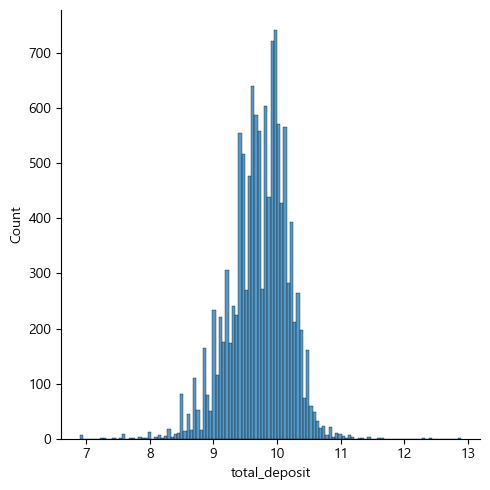

In [16]:
log_deposit = np.log1p(seongdong['total_deposit'])
sns.displot(log_deposit)

In [17]:
seongdong['total_deposit'] = np.log1p(seongdong['total_deposit'])

In [18]:
print('get_dummies() 수행 전 데이터 Shape:', seongdong.shape)
seongdong_ohe = pd.get_dummies(seongdong) # one-hot encoding 수행
print('get_dummies() 수행 후 데이터 Shape:', seongdong_ohe.shape)

get_dummies() 수행 전 데이터 Shape: (12211, 10)
get_dummies() 수행 후 데이터 Shape: (12211, 26)


In [19]:
# 타깃과 피처
y_target = seongdong_ohe['total_deposit']
X_features = seongdong_ohe.drop('total_deposit', axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                    y_target, 
                                                    test_size = 0.2, 
                                                    random_state = 2023)

In [20]:
# 일반 선형 회귀
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

# 라쏘 회귀
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

# 의사결정나무 회귀
decision_reg = DecisionTreeRegressor()
decision_reg.fit(X_train, y_train)

# 랜덤포레스트 회귀
randomforest_reg = RandomForestRegressor()
randomforest_reg.fit(X_train, y_train)

# XGboost
xgboost_reg = XGBRegressor()
xgboost_reg.fit(X_train, y_train)

# Lightgbm
lightgbm_reg = LGBMRegressor()
lightgbm_reg.fit(X_train, y_train)

LGBMRegressor()

In [21]:
#학습된 모델 전달하고
models = [lr_reg, ridge_reg, lasso_reg, decision_reg, randomforest_reg, xgboost_reg, lightgbm_reg]
# rmse값 반환
get_rmses(models)

LinearRegression RMSE: 0.353
Ridge RMSE: 0.353
Lasso RMSE: 0.404
DecisionTreeRegressor RMSE: 0.365
RandomForestRegressor RMSE: 0.273
XGBRegressor RMSE: 0.271
LGBMRegressor RMSE: 0.283


[0.3533141939318419,
 0.3533223075919646,
 0.4044738768227678,
 0.3647666536420788,
 0.273453432564213,
 0.27087366877362157,
 0.28281154802865877]

# 이상치 처리, 로그변환

In [22]:
seongdong = df_org.copy()

In [23]:
seongdong.drop(seongdong[(seongdong['use_area'] > 100) & (seongdong['total_deposit'] < 20000)].index, inplace=True)

In [24]:
seongdong = seongdong[seongdong['total_deposit'] <= 200000]
seongdong = seongdong[seongdong['total_deposit'] > 1000]
seongdong = seongdong[seongdong['use_area'] > 1]
seongdong.reset_index(drop = True, inplace = True)
seongdong.describe()

,date,build_year,floor,use_area,res_cnt,total_deposit,cctv_cnt,school_dis,sub_dis
count,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000
mean,4.123716,18.716093,2.991457,40.795801,263.860675,18411.165530,369.559106,0.244371,0.421660
std,2.326491,11.569046,1.738138,20.836880,233.184835,8246.581345,180.192851,0.134853,0.210158
min,1.000000,1.000000,-1.000000,8.960000,15.000000,1400.000000,19.000000,0.038938,0.041580
25%,2.000000,9.000000,2.000000,26.640000,64.000000,12809.000000,171.000000,0.146234,0.272563
50%,4.000000,17.000000,3.000000,36.960000,168.000000,17500.000000,403.000000,0.200793,0.369158
75%,6.000000,28.000000,4.000000,54.320000,431.000000,23000.000000,504.000000,0.342383,0.538121
max,8.000000,53.000000,17.000000,189.100000,958.000000,115000.000000,590.000000,0.524474,1.043076


In [25]:
seongdong['total_deposit'] = np.log1p(seongdong['total_deposit'])

In [26]:
print('get_dummies() 수행 전 데이터 Shape:', seongdong.shape)
seongdong_ohe = pd.get_dummies(seongdong) # one-hot encoding 수행
print('get_dummies() 수행 후 데이터 Shape:', seongdong_ohe.shape)

get_dummies() 수행 전 데이터 Shape: (12173, 10)
get_dummies() 수행 후 데이터 Shape: (12173, 26)


In [27]:
# 타깃과 피처
y_target = seongdong_ohe['total_deposit']
X_features = seongdong_ohe.drop('total_deposit', axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                    y_target, 
                                                    test_size = 0.2, 
                                                    random_state = 2023)

In [28]:
# 일반 선형 회귀
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

# 라쏘 회귀
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

# 의사결정나무 회귀
decision_reg = DecisionTreeRegressor()
decision_reg.fit(X_train, y_train)

# 랜덤포레스트 회귀
randomforest_reg = RandomForestRegressor()
randomforest_reg.fit(X_train, y_train)

# XGboost
xgboost_reg = XGBRegressor()
xgboost_reg.fit(X_train, y_train)

# Lightgbm
lightgbm_reg = LGBMRegressor()
lightgbm_reg.fit(X_train, y_train)

LGBMRegressor()

In [29]:
#학습된 모델 전달하고
models = [lr_reg, ridge_reg, lasso_reg, decision_reg, randomforest_reg, xgboost_reg, lightgbm_reg]
# rmse값 반환
get_rmses(models)

LinearRegression RMSE: 0.335
Ridge RMSE: 0.335
Lasso RMSE: 0.393
DecisionTreeRegressor RMSE: 0.357
RandomForestRegressor RMSE: 0.26
XGBRegressor RMSE: 0.256
LGBMRegressor RMSE: 0.262


[0.335187707554292,
 0.3351902361380245,
 0.3927736081135477,
 0.35716941613578634,
 0.26034233063675527,
 0.25598855007659277,
 0.2618194736629957]

# 이상치처리, 로그변환, 표준화

In [30]:
seongdong = df_org.copy()

In [31]:
seongdong.drop(seongdong[(seongdong['use_area'] > 100) & (seongdong['total_deposit'] < 20000)].index, inplace=True)

In [32]:
seongdong = seongdong[(seongdong['total_deposit'] <= 200000) & (seongdong['total_deposit'] > 1000)]
# seongdong = seongdong[seongdong['total_deposit'] > 1000]
seongdong = seongdong[seongdong['use_area'] > 1]
seongdong.reset_index(drop = True, inplace = True)
seongdong.describe()

,date,build_year,floor,use_area,res_cnt,total_deposit,cctv_cnt,school_dis,sub_dis
count,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000
mean,4.123716,18.716093,2.991457,40.795801,263.860675,18411.165530,369.559106,0.244371,0.421660
std,2.326491,11.569046,1.738138,20.836880,233.184835,8246.581345,180.192851,0.134853,0.210158
min,1.000000,1.000000,-1.000000,8.960000,15.000000,1400.000000,19.000000,0.038938,0.041580
25%,2.000000,9.000000,2.000000,26.640000,64.000000,12809.000000,171.000000,0.146234,0.272563
50%,4.000000,17.000000,3.000000,36.960000,168.000000,17500.000000,403.000000,0.200793,0.369158
75%,6.000000,28.000000,4.000000,54.320000,431.000000,23000.000000,504.000000,0.342383,0.538121
max,8.000000,53.000000,17.000000,189.100000,958.000000,115000.000000,590.000000,0.524474,1.043076


In [33]:
seongdong['total_deposit'] = np.log1p(seongdong['total_deposit'])

In [34]:
seongdong.shape

(12173, 10)

In [35]:
print('get_dummies() 수행 전 데이터 Shape:', seongdong.shape)
seongdong_ohe = pd.get_dummies(seongdong) # one-hot encoding 수행
print('get_dummies() 수행 후 데이터 Shape:', seongdong_ohe.shape)

get_dummies() 수행 전 데이터 Shape: (12173, 10)
get_dummies() 수행 후 데이터 Shape: (12173, 26)


In [36]:
# 타깃과 피처
y_target = seongdong_ohe['total_deposit']
X_features = seongdong_ohe.drop('total_deposit', axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                    y_target, 
                                                    test_size = 0.2, 
                                                    random_state = 2023)

In [37]:
# StandardScaler() Scaler객체를 생성.
std = StandardScaler()

# 학습 데이터에 대해서 fit(), transform() 수행.
std.fit(X_train)
scaled_X_train = std.transform(X_train)
scaled_X_test = std.transform(X_test)

In [38]:
# 단일 모델의 RMSE 값 반환
# RMSE : 평균 제곱근 오차를 의미하는 평가 지표 -> 이 값이 작을수록 모델의 예측 성능이 우수하다.
def get_rmse(model): # 학습된 모델을 받아서 예측
    pred = model.predict(scaled_X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse) # 루트를 씌워서 데이터 간의 격차를 줄여준다.
    print('{0} RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환/ 각각의 모델들에 대해서 rmse 를 리턴하는 함수를 만들겠다.
def get_rmses(models):
    rmses = [] # 반환된 각 모델의 rmse값을 저장한다.
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)    
    return rmses # 전달된 모델들의 rmse 값들이 저장된 list 가 반환이 된다.

In [39]:
# 일반 선형 회귀
lr_reg = LinearRegression()
lr_reg.fit(scaled_X_train, y_train)

# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(scaled_X_train, y_train)

# 라쏘 회귀
lasso_reg = Lasso()
lasso_reg.fit(scaled_X_train, y_train)

# 의사결정나무 회귀
decision_reg = DecisionTreeRegressor()
decision_reg.fit(scaled_X_train, y_train)

# 랜덤포레스트 회귀
randomforest_reg = RandomForestRegressor()
randomforest_reg.fit(scaled_X_train, y_train)

# XGboost
xgboost_reg = XGBRegressor()
xgboost_reg.fit(scaled_X_train, y_train)

# Lightgbm
lightgbm_reg = LGBMRegressor()
lightgbm_reg.fit(scaled_X_train, y_train)

LGBMRegressor()

In [40]:
#학습된 모델 전달하고
models = [lr_reg, ridge_reg, lasso_reg, decision_reg, randomforest_reg, xgboost_reg, lightgbm_reg]
# rmse값 반환
get_rmses(models)

LinearRegression RMSE: 0.335
Ridge RMSE: 0.335
Lasso RMSE: 0.464
DecisionTreeRegressor RMSE: 0.352
RandomForestRegressor RMSE: 0.262
XGBRegressor RMSE: 0.256
LGBMRegressor RMSE: 0.262


[0.335187707554292,
 0.33518935025595026,
 0.4640663024439999,
 0.352293772669501,
 0.26174111848223364,
 0.2560898537591888,
 0.26168777804083554]

# 범주형 제외시키고 결과값보기(별 차이 없다)

In [41]:
seongdong = df_org.copy()

In [42]:
seongdong.drop(seongdong[(seongdong['use_area'] > 100) & (seongdong['total_deposit'] < 20000)].index, inplace=True)

In [43]:
seongdong = seongdong[(seongdong['total_deposit'] <= 200000) & (seongdong['total_deposit'] > 1000)]
# seongdong = seongdong[seongdong['total_deposit'] > 1000]
seongdong = seongdong[seongdong['use_area'] > 1]
seongdong.reset_index(drop = True, inplace = True)

In [44]:
seongdong['total_deposit'] = np.log1p(seongdong['total_deposit'])

In [45]:
seongdong.drop(['date', 'dong'], axis = 1, inplace = True)

In [46]:
# 타깃과 피처
y_target = seongdong_ohe['total_deposit']
X_features = seongdong_ohe.drop('total_deposit', axis = 1, inplace = False)

X_train, X_test, y_train, y_test = train_test_split(X_features, 
                                                    y_target, 
                                                    test_size = 0.2, 
                                                    random_state = 2023)

In [47]:
# StandardScaler() Scaler객체를 생성.
std = StandardScaler()

# 학습 데이터에 대해서 fit(), transform() 수행.
std.fit(X_train)
scaled_X_train = std.transform(X_train)
scaled_X_test = std.transform(X_test)

In [48]:
# 단일 모델의 RMSE 값 반환
# RMSE : 평균 제곱근 오차를 의미하는 평가 지표 -> 이 값이 작을수록 모델의 예측 성능이 우수하다.
def get_rmse(model): # 학습된 모델을 받아서 예측
    pred = model.predict(scaled_X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse) # 루트를 씌워서 데이터 간의 격차를 줄여준다.
    print('{0} RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

# 여러 모델의 RMSE 값 반환/ 각각의 모델들에 대해서 rmse 를 리턴하는 함수를 만들겠다.
def get_rmses(models):
    rmses = [] # 반환된 각 모델의 rmse값을 저장한다.
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)    
    return rmses # 전달된 모델들의 rmse 값들이 저장된 list 가 반환이 된다.

In [49]:
# 일반 선형 회귀
lr_reg = LinearRegression()
lr_reg.fit(scaled_X_train, y_train)

# 릿찌회귀
ridge_reg = Ridge()
ridge_reg.fit(scaled_X_train, y_train)

# 라쏘 회귀
lasso_reg = Lasso()
lasso_reg.fit(scaled_X_train, y_train)

# 의사결정나무 회귀
decision_reg = DecisionTreeRegressor()
decision_reg.fit(scaled_X_train, y_train)

# 랜덤포레스트 회귀
randomforest_reg = RandomForestRegressor()
randomforest_reg.fit(scaled_X_train, y_train)

# XGboost
xgboost_reg = XGBRegressor()
xgboost_reg.fit(scaled_X_train, y_train)

# Lightgbm
lightgbm_reg = LGBMRegressor()
lightgbm_reg.fit(scaled_X_train, y_train)

LGBMRegressor()

In [50]:
#학습된 모델 전달하고
models = [lr_reg, ridge_reg, lasso_reg, decision_reg, randomforest_reg, xgboost_reg, lightgbm_reg]
# rmse값 반환
get_rmses(models)

LinearRegression RMSE: 0.335
Ridge RMSE: 0.335
Lasso RMSE: 0.464
DecisionTreeRegressor RMSE: 0.356
RandomForestRegressor RMSE: 0.26
XGBRegressor RMSE: 0.256
LGBMRegressor RMSE: 0.262


[0.335187707554292,
 0.33518935025595026,
 0.4640663024439999,
 0.35557041743914813,
 0.26035481620570294,
 0.2560898537591888,
 0.26168777804083554]

## 하이퍼 파라미터 설정

## Ridge, Lasso

In [51]:
def get_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid = params,
                             scoring = 'neg_mean_squared_error', cv = 5)
    grid_model.fit(scaled_X_train, y_train)
    rmse = np.sqrt(-1 * grid_model.best_score_)
 
    print('{0} 5 CV 시 최적 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_ # 최적 파라미터로 재학습되어 저장된 모델 반환

In [52]:
ridge_params = {'alpha' : [5, 10, 15, 20, 30, 40]}
lasso_params = {'alpha' : [0.001, 0.005, 0.05, 0.01, 0.1, 0.5]}

In [53]:
best_ridge = get_best_params(ridge_reg, ridge_params)
best_lasso = get_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 RMSE 값: 0.3308, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 RMSE 값: 0.3308, 최적 alpha:{'alpha': 0.001}


In [54]:
ridge_reg = Ridge(alpha = 10)
ridge_reg.fit(scaled_X_train, y_train)

lasso_reg = Lasso(alpha = 0.001)
lasso_reg.fit(scaled_X_train, y_train)

Lasso(alpha=0.001)

## RandomForest

In [55]:
# 테스트해볼 데이터(파라미터 값)를 많이 넣으면 기하급수적으로 늘어난다
params = {
    'n_estimators': [100],
    'max_depth': [16, 18, 20, 22, 24],
    'min_samples_split': [2, 4, 6, 8],
    'min_samples_leaf': [2, 4, 6, 8]
}

randomforest_reg = RandomForestRegressor(random_state = 2023, n_jobs=-1)

grid_cv = GridSearchCV(randomforest_reg, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(scaled_X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
최고 예측 정확도: 0.6537


In [56]:
randomforest_reg = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_leaf=2, min_samples_split = 4,
                                 random_state=2023, n_jobs=-1)
randomforest_reg.fit(scaled_X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=4,
                      n_jobs=-1, random_state=2023)

## XGboost

In [57]:
param_grid = {
    'n_estimators': [300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 10], 
    'learning_rate' : [0.1, 0.2, 0.3], 
    'random_state' : [1, 10, 20] 

}

# 그리드 서치 객체 생성
grid_search = GridSearchCV(estimator=xgboost_reg, param_grid = param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# 그리드 서치 수행
grid_search.fit(scaled_X_train, y_train)

# 최적의 하이퍼파라미터 출력
print("최적의 하이퍼파라미터:", grid_search.best_params_)

최적의 하이퍼파라미터: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500, 'random_state': 1}


In [58]:
xgboost_reg = XGBRegressor(
                           n_estimators=500,
                           learning_rate=0.1,
                           max_depth=5,
                           objective='reg:squarederror',
                           random_state=1
)
xgboost_reg.fit(scaled_X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

## DecisionTree

In [59]:
# 테스트해볼 데이터(파라미터 값)를 많이 넣으면 기하급수적으로 늘어난다
params = {
    'max_features' : ['sqrt', 'log', 'None'],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14]
}

decision_reg = DecisionTreeRegressor(random_state = 2023)

grid_cv = GridSearchCV(decision_reg, param_grid=params, cv=2)
grid_cv.fit(scaled_X_train, y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 12, 'min_samples_split': 2}
최고 예측 정확도: 0.5083


In [60]:
decision_reg = DecisionTreeRegressor(max_depth = 14,
                                     max_features = 'sqrt',
                                     min_samples_leaf = 12,
                                     min_samples_split = 2)
decision_reg.fit(scaled_X_train, y_train)

DecisionTreeRegressor(max_depth=14, max_features='sqrt', min_samples_leaf=12)

## LightGBM

In [61]:
# LightGBM 상세도를 줄이기 위해 설정
lightgbm_reg.set_params(verbosity=-1)

LGBMRegressor(verbosity=-1)

In [62]:
# 하이퍼파라미터 튜닝을 위한 매개변수 그리드 정의
param_grid = {
    'boosting_type': ['gbdt'],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 7, 10],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

In [63]:
# 그리드 서치를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=lightgbm_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(scaled_X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(verbosity=-1),
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.8, 0.9, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [5, 7, 10],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 0.9, 1.0]},
             scoring='neg_mean_squared_error')

In [64]:
grid_search.cv_results_['mean_test_score'].mean()

-0.07630380638540102

In [65]:
# 최적의 매개변수 얻기
best_params = grid_search.best_params_

In [66]:
# 최적의 매개변수로 모델 훈련
lightgbm_reg = lgb.LGBMRegressor(**best_params)
lightgbm_reg.fit(scaled_X_train, y_train)

LGBMRegressor(colsample_bytree=0.8, max_depth=7, n_estimators=300,
              subsample=0.8)

In [67]:
# model = [lightgbm_reg]
# get_rmses(model)

In [68]:
models = [ridge_reg, lasso_reg, randomforest_reg, xgboost_reg, decision_reg, lightgbm_reg]
get_rmses(models)

Ridge RMSE: 0.335
Lasso RMSE: 0.335
RandomForestRegressor RMSE: 0.258
XGBRegressor RMSE: 0.253
DecisionTreeRegressor RMSE: 0.322
LGBMRegressor RMSE: 0.25


[0.3352044122853719,
 0.33528065720083644,
 0.2579103420654252,
 0.2525796250999271,
 0.3218326500500819,
 0.2501080449185534]

## 모델링 결과

### 원데이터
- LinearRegression RMSE: 7024.544
- Ridge RMSE: 7024.62
- Lasso RMSE: 7024.429
- DecisionTreeRegressor RMSE: 6609.919
- RandomForestRegressor RMSE: 5248.741
- XGBRegressor RMSE: 5742.972
- LGBMRegressor RMSE: 5212.359
---
### 로그 변환
- LinearRegression RMSE: 0.353
- Ridge RMSE: 0.353
- Lasso RMSE: 0.404
- DecisionTreeRegressor RMSE: 0.363
- RandomForestRegressor RMSE: 0.273
- XGBRegressor RMSE: 0.271
- LGBMRegressor RMSE: 0.283
---
### 이상치처리, 로그변환
- LinearRegression RMSE: 0.335
- Ridge RMSE: 0.335
- Lasso RMSE: 0.393
- DecisionTreeRegressor RMSE: 0.351
- RandomForestRegressor RMSE: 0.261
- XGBRegressor RMSE: 0.256
- LGBMRegressor RMSE: 0.26
---
### 이상치처리, 로그변환, 표준화
- LinearRegression RMSE: 0.335
- Ridge RMSE: 0.335
- Lasso RMSE: 0.464
- DecisionTreeRegressor RMSE: 0.344
- RandomForestRegressor RMSE: 0.261
- XGBRegressor RMSE: 0.256
- LGBMRegressor RMSE: 0.262
---
### 최적의 하이퍼파라미터 적용
- Ridge RMSE: 0.335
- Lasso RMSE: 0.335
- DecisionTreeRegressor RMSE: 0.323
- RandomForestRegressor RMSE: 0.258
- XGBRegressor RMSE: 0.253
- LGBMRegressor RMSE: 0.25

In [89]:
regressor_line.set_index(pd.Index(['Log', 'Log&Outlier', 'Log&Outlier&Stdzn', 'Hyperparameter']))

,Linear,Ridge,Lasso,Decision,RandomForest,XGB,LGBM
Log,0.353,0.353,0.404,0.363,0.273,0.271,0.283
Log&Outlier,0.335,0.335,0.393,0.351,0.261,0.256,0.260
Log&Outlier&Stdzn,0.335,0.335,0.464,0.344,0.261,0.256,0.262
Hyperparameter,0.335,0.335,0.335,0.323,0.258,0.253,0.250


In [69]:
regressor_line = pd.DataFrame({'Linear' : ['0.353', '0.335', '0.335', '0.335'],
                               'Ridge' : ['0.353', '0.335', '0.335', '0.335'],
                               'Lasso' : ['0.404', '0.393', '0.464', '0.335'],
                               'Decision' : ['0.363', '0.351', '0.344', '0.323'],
                               'RandomForest' : ['0.273', '0.261', '0.261', '0.258'],
                               'XGB' : ['0.271', '0.256', '0.256', '0.253'],
                               'LGBM' : ['0.283', '0.26', '0.262', '0.25']})

In [70]:
regressor_line

,Linear,Ridge,Lasso,Decision,RandomForest,XGB,LGBM
0,0.353,0.353,0.404,0.363,0.273,0.271,0.283
1,0.335,0.335,0.393,0.351,0.261,0.256,0.26
2,0.335,0.335,0.464,0.344,0.261,0.256,0.262
3,0.335,0.335,0.335,0.323,0.258,0.253,0.25


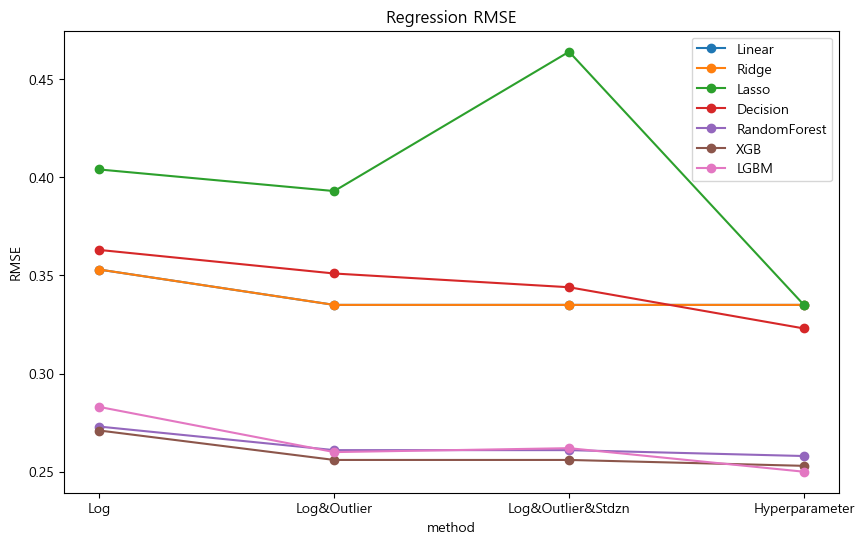

In [71]:
regressor_line = regressor_line.astype(float)
regressor_line.index = ['Log', 'Log&Outlier', 'Log&Outlier&Stdzn', 'Hyperparameter']

plt.figure(figsize=(10, 6))  
for column in regressor_line.columns:
    plt.plot(regressor_line.index, regressor_line[column], marker='o', label=column)

plt.title('Regression RMSE')

plt.ylabel('RMSE')
plt.xlabel('method')
plt.legend()
plt.grid(False)
plt.show()

In [72]:
lightgbm_reg = lgb.LGBMRegressor(colsample_bytree=0.8, max_depth=7, n_estimators=300, subsample=0.8)
lightgbm_reg.fit(scaled_X_train, y_train)

LGBMRegressor(colsample_bytree=0.8, max_depth=7, n_estimators=300,
              subsample=0.8)

In [73]:
final_lgb_pred = np.expm1(lightgbm_reg.predict(scaled_X_test))
final_lgb_pred

array([17424.85289739, 20973.47015688, 11354.00298872, ...,
        7230.19619035,  8008.40754689, 16739.45359404])

In [74]:
y_test

3392     9.841665
5217     9.998843
9181     9.741027
1556     9.741027
4038     9.492960
           ...   
2778     9.210440
10189    9.116140
1156     8.853808
264      9.205629
2832     9.609184
Name: total_deposit, Length: 2435, dtype: float64

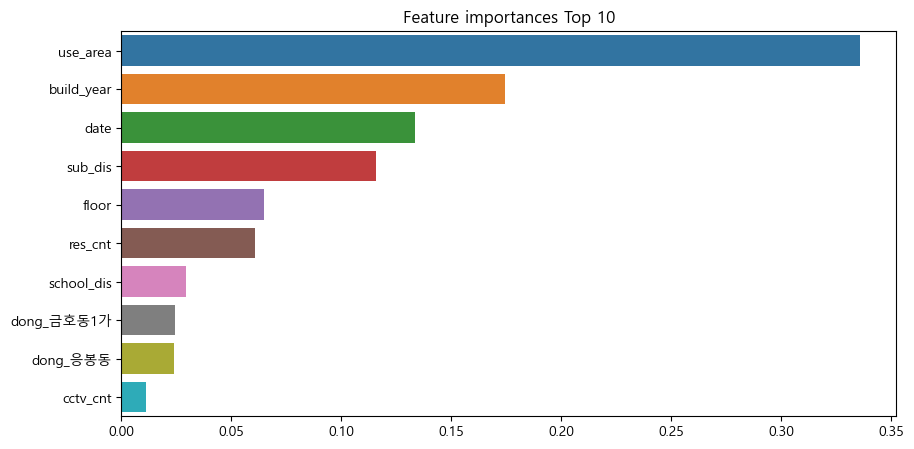

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = decision_reg.feature_importances_ ## feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(10,5))
plt.title('Feature importances Top 10')
sns.barplot(x=ftr_top10, y=ftr_top10.index)
plt.show()

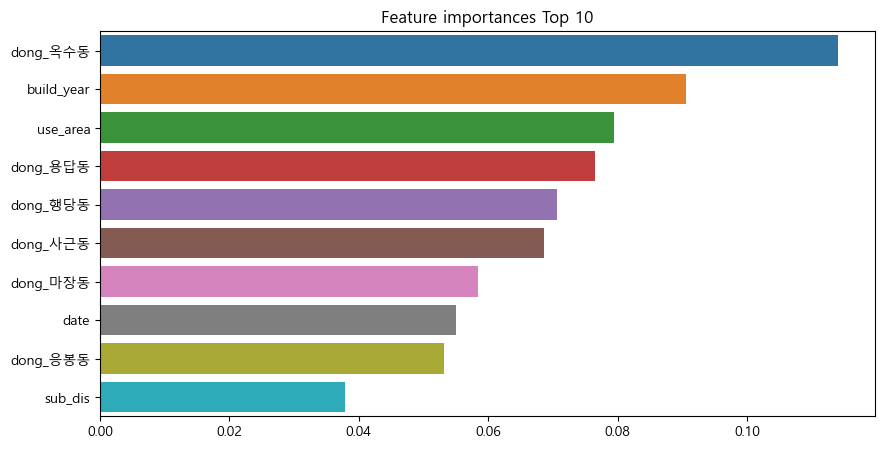

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = xgboost_reg.feature_importances_ ## feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(10,5))
plt.title('Feature importances Top 10')
sns.barplot(x=ftr_top10, y=ftr_top10.index)
plt.show()

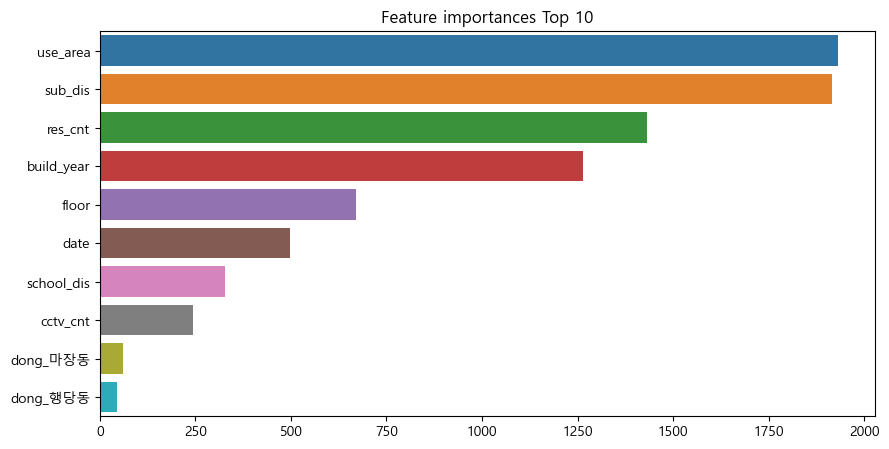

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = lightgbm_reg.feature_importances_ ## feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top10 = ftr_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(10,5))
plt.title('Feature importances Top 10')
sns.barplot(x=ftr_top10, y=ftr_top10.index)
plt.show()

In [78]:
lightgbm_reg = lgb.LGBMRegressor(colsample_bytree=0.8, max_depth=7, n_estimators=300, subsample=0.8)
lightgbm_reg.fit(scaled_X_train, y_train)

LGBMRegressor(colsample_bytree=0.8, max_depth=7, n_estimators=300,
              subsample=0.8)

In [79]:
## 예측값과 실제값 그래프로 확인해보기

In [80]:
# 예측값
final_lgb_pred = np.expm1(lightgbm_reg.predict(scaled_X_test))
final_lgb_pred

array([17424.85289739, 20973.47015688, 11354.00298872, ...,
        7230.19619035,  8008.40754689, 16739.45359404])

In [81]:
# 실제값 
y_test_exp = np.expm1(y_test)
y_test_exp

3392     18800.0
5217     22000.0
9181     17000.0
1556     17000.0
4038     13265.0
          ...   
2778     10000.0
10189     9100.0
1156      7000.0
264       9952.0
2832     14900.0
Name: total_deposit, Length: 2435, dtype: float64

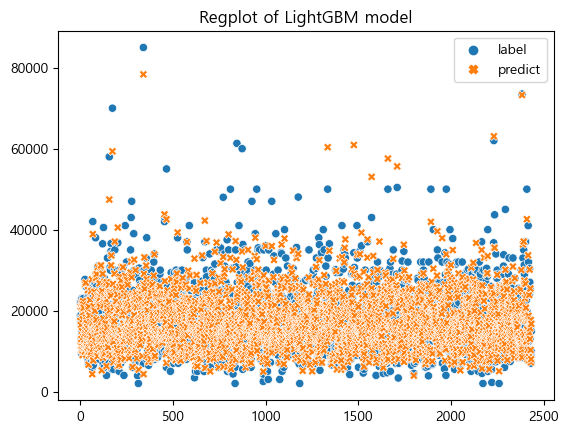

In [82]:
# 가시성이 좋지 않으므로 사용 X
result = pd.concat([y_test_exp.reset_index(drop=True), pd.DataFrame(final_lgb_pred)], axis = 1)
result.columns = ['label','predict']
sns.scatterplot(data=result)
plt.title('Regplot of LightGBM model')
plt.show()

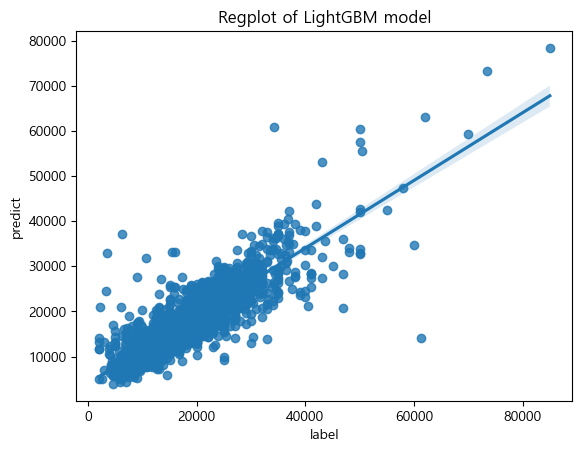

In [83]:
result = pd.concat([y_test_exp.reset_index(drop=True), pd.DataFrame(final_lgb_pred)], axis = 1)
result.columns = ['label','predict']
sns.regplot(x='label', y='predict', data=result)
plt.title('Regplot of LightGBM model')
plt.show()

## 예측 프로세스 만들기

In [84]:
# 패키지 불러오기
import pickle
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
import lightgbm as lgb

# 모델 로딩
with open("lightgbm_reg.pkl", "rb") as f:
    model = pickle.load(f)

In [85]:
# lightbgm_reg가 잘 불러와지는지 확인
model

LGBMRegressor(colsample_bytree=0.8, max_depth=7, n_estimators=300,
              subsample=0.8)

In [86]:
# 동별 고정 값 데이터 프레임 불러오기
dong_data = pd.read_csv('dong_data.csv', index_col = 0)
dong_data

,res_cnt,cctv_cnt,school_dis,sub_dis
dong,,,,
금호동1가,37.960581,118.0,0.157064,0.342363
금호동2가,55.974359,95.0,0.192920,0.276348
금호동3가,75.742754,134.0,0.132526,0.512226
금호동4가,64.256637,195.0,0.274937,0.292758
도선동,109.175000,66.0,0.038938,0.301215
마장동,124.433573,403.0,0.209327,0.343866
사근동,32.600694,171.0,0.146234,0.348911
상왕십리동,18.000000,19.0,0.524474,0.444020
성수동1가,356.007640,483.0,0.501694,0.440170


In [104]:
def predict_program():
    dong_name = ['금호동1가', '금호동2가', '금호동3가',
       '금호동4가', '도선동', '마장동', '사근동', '상왕십리동',
       '성수동1가', '성수동2가', '송정동', '옥수동', '용답동',
       '응봉동', '하왕십리동', '행당동', '홍익동']
    
    dong_dict = {}
    
    n = 8
    for i in dong_name:
        dong_dict[i] = n
        n += 1
        
    by = int(input('원하는 건축년도를 입력하세요(10년된 건물 = 10):'))
    floor = int(input('원하는 층수를 입력하세요(반지하 = -1):'))
    use_area = float(input('원하는 전용면적을 입력하세요(15평 = 45.59㎡):'))
    print('성동구 동 리스트', dong_name)
    dong = input('원하는 동을 입력하세요:') 
    res = dong_data.loc[dong][0]
    cctv = dong_data.loc[dong][1]
    school = dong_data.loc[dong][2]
    sub = dong_data.loc[dong][3]
    
    pred_data = np.array([[0, by, floor, use_area, res, cctv, school, sub, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
    pred_data[0][dong_dict[dong]] = 1
    
    prediction = int(np.expm1(model.predict(pred_data)))
    print()
    print('귀하가 입력하신 데이터에 대한 전세값:', prediction,'만원')

In [107]:
predict_program()

원하는 건축년도를 입력하세요(10년된 건물 = 10):3
원하는 층수를 입력하세요(반지하 = -1):2
원하는 전용면적을 입력하세요(15평 = 45.59㎡):45.59
성동구 동 리스트 ['금호동1가', '금호동2가', '금호동3가', '금호동4가', '도선동', '마장동', '사근동', '상왕십리동', '성수동1가', '성수동2가', '송정동', '옥수동', '용답동', '응봉동', '하왕십리동', '행당동', '홍익동']
원하는 동을 입력하세요:옥수동

귀하가 입력하신 데이터에 대한 전세값: 48425 만원
